In [1]:
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt 
from models.gru import GRU
from losses.correlation_loss import CorrelationLoss
from losses.hybrid_loss import HybridLoss
from models.attention_gru import AttentionGRU
import gc
import random

In [120]:
def evaluate_model(model, test_loader, device, custom=False):
    model.eval()
    # total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_features, batch_targets in test_loader:
            # Move data to device
            batch_features = batch_features.to(device)
            batch_targets = batch_targets.to(device)
            
            # Get model predictions

            
            if custom:
                predictions, _ = model(batch_features, batch_features)
            else:
                predictions = model(batch_features)
            
            # Take the last time step predictions
            if custom:
                predictions = predictions[:, -1, :]

            # loss = criterion(predictions, batch_targets)
            # total_loss += loss.item()
            
            # Collect predictions and targets
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(batch_targets.cpu().numpy())
    
    # Concatenate all predictions and targets
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    return all_predictions, all_targets, 0

def plot_results(y_true, y_pred, feature_name, feature_index):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:, feature_index], label="Actual", linestyle='', marker='o')
    plt.plot(y_pred[:, feature_index], label="Predicted", linestyle='', marker='x')
    plt.title(f"Actual vs Predicted {feature_name}", fontsize=16)
    plt.xlabel("Timestep", fontsize=14)
    plt.ylabel(feature_name, fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

In [4]:
paths = ["../datasets/btc-2024-11-25.csv",
        "../datasets/btc-2024-11-24.csv",
        "../datasets/btc-2024-11-23.csv",
        "../datasets/btc-2024-11-22.csv",
        "../datasets/btc-2024-11-21.csv",
        "../datasets/btc-2024-11-20.csv",
        "../datasets/btc-2024-11-19.csv",
        "../datasets/btc-2024-11-18.csv"]

paths = [path.replace("../datasets/", "/pool/btcavax/binance-usdtfutures/depth-25/btc/").replace("btc-", "") for path in paths]



data_df = pd.DataFrame()
for path in paths:
    data_df = pd.concat([data_df, pd.read_csv(path, sep="|")])

In [7]:
data_df["datetime"] = pd.to_datetime(data_df["time"], unit="us")
data_df.set_index("datetime", inplace=True)
data_copy = data_df.copy()

In [ ]:
data_df = data_df.resample("1s").last().ffill()

In [102]:
data_5min_df = data_copy.resample("5min").last().ffill()

In [9]:
import itertools
data_df["midprice"] = (data_df["bid_0_price"] + data_df["ask_0_price"]) / 2
data_df["bid_volume"] = data_df[[f"bid_{i}_size" for i in range(25)]].sum(axis=1)
data_df["ask_volume"] = data_df[[f"ask_{i}_size" for i in range(25)]].sum(axis=1)
data_df["total_volume"] = data_df["bid_volume"] + data_df["ask_volume"]
data_df["spread"] = (data_df["ask_0_price"] - data_df["bid_0_price"]) / data_df["ask_0_price"]
data_df["log_return"] = np.log(data_df["midprice"]) - np.log(data_df["midprice"].shift(1))
data_df["ob_imb"] = (data_df["bid_volume"] - data_df["ask_volume"]) / (data_df["total_volume"])
data_df["vwap"] = (data_df["midprice"] * data_df["total_volume"]).cumsum() / data_df["total_volume"].cumsum()
data_df["ofi"] = (data_df["bid_0_price"].diff() > 0) * data_df["bid_0_size"] \
    - (data_df["bid_0_price"].diff() < 0) * data_df["bid_0_size"].shift(1) \
    + (data_df["ask_0_price"].diff() < 0) * data_df["ask_0_size"] \
    - (data_df["ask_0_price"].diff() > 0) * data_df["ask_0_size"].shift(1)

data_df["target_log_return"] = data_df["log_return"].shift(-1)
    
lagged_features = ["log_return", "vwap", "spread", "midprice"]
lagged_col_names = []

for (lag, feature) in itertools.product([1, 10, 60], lagged_features):
    data_df[f"{feature}_lag_{lag}"] = data_df[feature].shift(lag)
    lagged_col_names.append(f"{feature}_lag_{lag}")

data_df.dropna(inplace=True)

In [104]:
import itertools
data_5min_df["midprice"] = (data_5min_df["bid_0_price"] + data_5min_df["ask_0_price"]) / 2
data_5min_df["bid_volume"] = data_5min_df[[f"bid_{i}_size" for i in range(25)]].sum(axis=1)
data_5min_df["ask_volume"] = data_5min_df[[f"ask_{i}_size" for i in range(25)]].sum(axis=1)
data_5min_df["total_volume"] = data_5min_df["bid_volume"] + data_5min_df["ask_volume"]
data_5min_df["spread"] = (data_5min_df["ask_0_price"] - data_5min_df["bid_0_price"]) / data_5min_df["ask_0_price"]
data_5min_df["log_return"] = np.log(data_5min_df["midprice"]) - np.log(data_5min_df["midprice"].shift(1))
data_5min_df["ob_imb"] = (data_5min_df["bid_volume"] - data_5min_df["ask_volume"]) / (data_5min_df["total_volume"])
data_5min_df["vwap"] = (data_5min_df["midprice"] * data_5min_df["total_volume"]).cumsum() / data_5min_df["total_volume"].cumsum()
data_5min_df["ofi"] = (data_5min_df["bid_0_price"].diff() > 0) * data_5min_df["bid_0_size"] \
    - (data_5min_df["bid_0_price"].diff() < 0) * data_5min_df["bid_0_size"].shift(1) \
    + (data_5min_df["ask_0_price"].diff() < 0) * data_5min_df["ask_0_size"] \
    - (data_5min_df["ask_0_price"].diff() > 0) * data_5min_df["ask_0_size"].shift(1)

data_5min_df["target_log_return"] = data_5min_df["log_return"].shift(-1)
    
lagged_features = ["log_return", "vwap", "spread", "midprice"]
lagged_col_names = []

for (lag, feature) in itertools.product([1, 10, 60], lagged_features):
    data_5min_df[f"{feature}_lag_{lag}"] = data_5min_df[feature].shift(lag)
    lagged_col_names.append(f"{feature}_lag_{lag}")

data_5min_df.dropna(inplace=True)

In [10]:
feature_cols = ["midprice", "bid_volume", "ask_volume", "total_volume", "spread", "log_return", "ob_imb", "vwap", "ofi"] \
    + [f"bid_{i}_size" for i in range(2)] \
    + [f"bid_{i}_price" for i in range(2)] \
    + [f"ask_{i}_size" for i in range(2)] \
    + [f"ask_{i}_price" for i in range(2)] \
    + lagged_col_names

target_cols = ["target_log_return"]

In [11]:
from sklearn.preprocessing import StandardScaler

data_scaled = data_df.copy()

split_idx = int(len(data_df) * 0.8)

scaler = StandardScaler()
scaler.fit(data_scaled.iloc[split_idx:][feature_cols])

data_scaled[feature_cols] = scaler.transform(data_scaled[feature_cols])

train_df = data_scaled.iloc[:split_idx]
test_df = data_scaled.iloc[split_idx:]

In [105]:
from sklearn.preprocessing import StandardScaler

data_scaled_5min = data_5min_df.copy()

split_idx = int(len(data_5min_df) * 0.8)

scaler_5min = StandardScaler()
scaler_5min.fit(data_scaled_5min.iloc[split_idx:][feature_cols])

data_scaled_5min[feature_cols] = scaler.transform(data_scaled_5min[feature_cols])

train_5min_df = data_scaled.iloc[:split_idx]
test_5min_df = data_scaled.iloc[split_idx:]

In [12]:
unscaled_train_df = data_df.iloc[:split_idx]
unscaled_test_df = data_df.iloc[split_idx:]

In [107]:
class BtcDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [108]:
# Create sequences for AttentionGRU
def create_sequences(features, targets, seq_length=5):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(targets[i + seq_length])
    return torch.stack(X), torch.stack(y)

In [109]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
PARAMS = {
    "sequence_length": 50,
    "hidden_dim": 64,
    "epochs": 100,
    "batch_size": 32,
    "lr": 0.0005,
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
unscaled_train_features_df = unscaled_train_df[feature_cols]
unscaled_train_targets_df = unscaled_train_df[target_cols]

unscaled_test_features_df = unscaled_test_df[feature_cols]
unscaled_test_targets_df = unscaled_test_df[target_cols]

In [18]:
train_features_df = train_df[feature_cols]
train_targets_df = train_df[target_cols]

test_features_df = test_df[feature_cols]
test_targets_df = test_df[target_cols]

train_features = torch.tensor(train_features_df.values, dtype=torch.float32).to(device)
train_targets = torch.tensor(train_targets_df.values, dtype=torch.float32).to(device)
test_features = torch.tensor(test_features_df.values, dtype=torch.float32).to(device)
test_targets = torch.tensor(test_targets_df.values, dtype=torch.float32).to(device)

train_features, train_targets = create_sequences(train_features, train_targets, PARAMS["sequence_length"])
test_features, test_targets = create_sequences(test_features, test_targets, PARAMS["sequence_length"])

In [112]:
train_features_5min_df = train_5min_df[feature_cols]
train_targets_5min_df = train_5min_df[target_cols]

test_features_5min_df = test_5min_df[feature_cols]
test_targets_5min_df = test_5min_df[target_cols]

train_features_5min = torch.tensor(train_features_5min_df.values, dtype=torch.float32).to(device)
train_targets_5min = torch.tensor(train_targets_5min_df.values, dtype=torch.float32).to(device)
test_features_5min = torch.tensor(train_features_5min_df.values, dtype=torch.float32).to(device)
test_targets_5min = torch.tensor(train_targets_5min_df.values, dtype=torch.float32).to(device)

train_features_5min, train_targets_5min = create_sequences(train_features_5min, train_targets_5min, PARAMS["sequence_length"])
test_features_5min, test_targets_5min = create_sequences(test_features_5min, test_targets_5min, PARAMS["sequence_length"])

In [19]:
train_dataset = BtcDataset(train_features, train_targets)
test_dataset = BtcDataset(test_features, test_targets)

train_loader = DataLoader(train_dataset, batch_size=PARAMS["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=PARAMS["batch_size"], shuffle=False)

In [113]:
train_dataset_5min = BtcDataset(train_features_5min, train_targets_5min)
test_dataset_5min = BtcDataset(test_features_5min, test_targets_5min)

train_loader_5min = DataLoader(train_dataset_5min, batch_size=PARAMS["batch_size"], shuffle=False)
test_loader_5min = DataLoader(test_dataset_5min, batch_size=PARAMS["batch_size"], shuffle=False)

In [114]:
class TorchGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(TorchGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # GRU forward pass
        out, _ = self.gru(x, h0)
        
        # Take the output of the last time step
        out = out[:, -1, :]
        
        # Pass through fully connected layer
        out = self.fc(out)
        return out

In [115]:
torch_gru = TorchGRU(input_size=len(feature_cols), hidden_size=PARAMS["hidden_dim"], output_size=len(target_cols)).to(device)
criterion = HybridLoss(0.1)
optimizer = torch.optim.Adam(torch_gru.parameters(), lr=PARAMS["lr"])

for epoch in range(PARAMS["epochs"]):
    torch_gru.train()  # Set the gru_model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader_5min:
        inputs, targets = inputs.float(), targets.float()

        optimizer.zero_grad()

        outputs = torch_gru(inputs)

        loss = criterion(outputs, targets)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = running_loss / len(train_loader_5min)
    print(f"Epoch {epoch+1}/{PARAMS["epochs"]}, Training Loss: {avg_train_loss:.4f}")

Epoch 1/100, Training Loss: 0.7930
Epoch 2/100, Training Loss: 0.7303
Epoch 3/100, Training Loss: 0.7128
Epoch 4/100, Training Loss: 0.6844
Epoch 5/100, Training Loss: 0.6671
Epoch 6/100, Training Loss: 0.6637
Epoch 7/100, Training Loss: 0.6538
Epoch 8/100, Training Loss: 0.6473
Epoch 9/100, Training Loss: 0.6321
Epoch 10/100, Training Loss: 0.6276
Epoch 11/100, Training Loss: 0.6257
Epoch 12/100, Training Loss: 0.6201
Epoch 13/100, Training Loss: 0.6237
Epoch 14/100, Training Loss: 0.6165
Epoch 15/100, Training Loss: 0.6176
Epoch 16/100, Training Loss: 0.6186
Epoch 17/100, Training Loss: 0.6207
Epoch 18/100, Training Loss: 0.6070
Epoch 19/100, Training Loss: 0.6066
Epoch 20/100, Training Loss: 0.6055
Epoch 21/100, Training Loss: 0.6034
Epoch 22/100, Training Loss: 0.6014
Epoch 23/100, Training Loss: 0.6000
Epoch 24/100, Training Loss: 0.6006
Epoch 25/100, Training Loss: 0.6022
Epoch 26/100, Training Loss: 0.6048
Epoch 27/100, Training Loss: 0.6052
Epoch 28/100, Training Loss: 0.5955
E

In [135]:
from sklearn.metrics import mean_squared_error

preds, targets, _ = evaluate_model(torch_gru, test_loader_5min, device)

preds = preds[:, 0]
targets = targets[:, 0]

a = np.mean((preds * targets) > 0)
b = np.mean((preds * targets) > 0) + np.mean((preds * targets) < 0)
print("direction:", a/b)
print("corr:", np.corrcoef(preds, targets)[0, 1])
print("mse:", mean_squared_error(preds, targets))

direction: 0.5138427464008859
corr: 0.09325353841191816
mse: 0.00012548315862659365


0.7342669343904993 similarity
0.27310407793758595 corr
6.79524732404716e-09 MSE


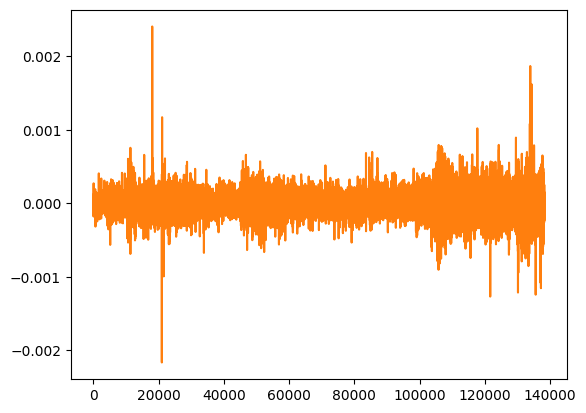

In [ ]:
#####################
# LINEAR REGRESSION #
#####################
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(train_features_df.values, train_targets_df.values)

lr_preds = lr.predict(test_features_df.values)

plt.plot(lr_preds)
plt.plot(test_targets_df.values)

a = np.mean((lr_preds * test_targets_df.values) > 0)
b = np.mean((lr_preds * test_targets_df.values) > 0) + np.mean((lr_preds * test_targets_df.values) < 0)

print(a/b, "similarity")
print(np.corrcoef(lr_preds.T, test_targets_df.values.T)[0, 1], "corr")
print(mean_squared_error(lr_preds, test_targets_df.values), "MSE")


In [ ]:
################
# Boosted Tree #
################

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Create LightGBM dataset objects
train_data = lgb.Dataset(unscaled_train_features_df, label=unscaled_train_targets_df)
test_data = lgb.Dataset(unscaled_test_features_df, label=unscaled_test_targets_df, reference=train_data)

# Define LightGBM parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train the LightGBM model
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],  # For training and validation
    valid_names=['train', 'valid'],
    num_boost_round=20,  # Maximum number of boosting iterations
)

# Make predictions
gbm_pred = model.predict(unscaled_test_features_df, num_iteration=model.best_iteration)

# Evaluate the model
a = np.mean((gbm_pred * test_targets_df.values[:, 0]) > 0)
b = np.mean((gbm_pred * test_targets_df.values[:, 0]) > 0) + np.mean((gbm_pred * test_targets_df.values[:, 0]) < 0)

print(a/b, "similarity")
print(np.corrcoef(unscaled_test_targets_df.values[:, 0], gbm_pred)[0, 1], "corr")
print(mean_squared_error(gbm_pred, unscaled_test_targets_df.values), "MSE")

0.7465719336182189 similarity
0.30141117462693073 corr
6.8938560376080966e-09 MSE


/home/mglass/gru-with-attention/venv/lib64/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 0.1651772769398572


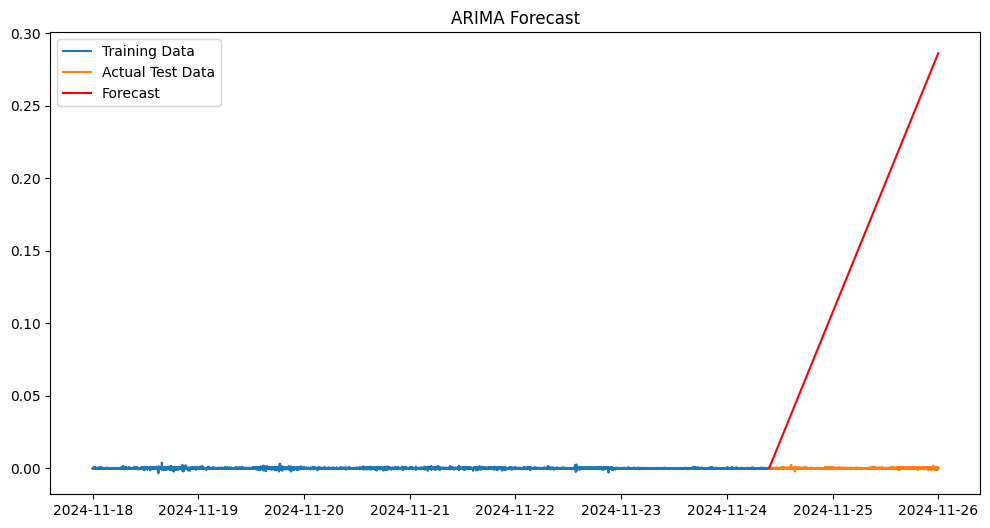

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Ensure target data is a single time series
# Replace 'target_column_name' with the actual column name of your target
arima_train = unscaled_train_df["log_return"]
arima_test = unscaled_test_df["log_return"]
# train_targets = unscaled_train_targets_df['m']
# test_targets = unscaled_test_targets_df['target_log_return']

# Fit ARIMA model
# Define the ARIMA order (p, d, q)
# These values should be chosen based on model selection (e.g., AIC, BIC) or grid search
order = (2, 1, 2)  # Example: AR(5), I(1), MA(0)

# Train the model
model = ARIMA(arima_train, order=order)
model_fit = model.fit()

# Forecast
forecast_steps = len(arima_test)
forecast = model_fit.forecast(steps=forecast_steps)

# Evaluate the model
mse = mean_squared_error(arima_test, forecast)
rmse = np.sqrt(mse)

print("Test RMSE:", rmse)

# Optional: Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(arima_train.index, arima_train, label='Training Data')
plt.plot(arima_test.index, arima_test, label='Actual Test Data')
plt.plot(arima_test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()

In [ ]:
gru_model = GRU(input_size=len(feature_cols), hidden_size=PARAMS["hidden_dim"], output_size=len(target_cols), device=device).to(device)
criterion = CorrelationLoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=PARAMS["lr"])

for epoch in range(PARAMS["epochs"]):
    gru_model.train()  # Set the gru_model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.float(), targets.float()

        optimizer.zero_grad()

        outputs = gru_model(inputs)

        loss = criterion(outputs, targets)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{PARAMS["epochs"]}, Training Loss: {avg_train_loss:.4f}")

In [159]:
attention_gru = AttentionGRU(len(feature_cols), PARAMS["hidden_dim"], len(feature_cols), len(target_cols), device).to(device)
criterion = HybridLoss(0.1)
optimizer = torch.optim.Adam(attention_gru.parameters(), lr=PARAMS["lr"])

for epoch in range(PARAMS["epochs"]):
    attention_gru.train()
    epoch_loss = 0

    for batch_features, batch_targets in train_loader_5min:
        optimizer.zero_grad()
        outputs, _ = attention_gru(batch_features, batch_features)
        loss = criterion(outputs[:, -1, :], batch_targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(attention_gru.parameters(), max_norm=1.0)

        optimizer.step()
        epoch_loss += loss.item()
    print(f"epoch: {epoch+1}, loss: {epoch_loss/len(train_loader_5min)}")

epoch: 1, loss: 0.8080758463252674
epoch: 2, loss: 0.7782025824893605
epoch: 3, loss: 0.7715155753222379
epoch: 4, loss: 0.7645658205855976
epoch: 5, loss: 0.7438133060932159
epoch: 6, loss: 0.741147780418396
epoch: 7, loss: 0.7406544116410342
epoch: 8, loss: 0.7510960920290514
epoch: 9, loss: 0.747745715488087
epoch: 10, loss: 0.7589130000634627
epoch: 11, loss: 0.7139680846170946
epoch: 12, loss: 0.7168089015917345
epoch: 13, loss: 0.7114133406769145
epoch: 14, loss: 0.7008711435578087
epoch: 15, loss: 0.7016276066953485
epoch: 16, loss: 0.7033579322424802
epoch: 17, loss: 0.6984248329292644
epoch: 18, loss: 0.704178205945275
epoch: 19, loss: 0.6860747039318085
epoch: 20, loss: 0.6975509925322099
epoch: 21, loss: 0.6789866479960355
epoch: 22, loss: 0.6958541805093938
epoch: 23, loss: 0.6726328307932073
epoch: 24, loss: 0.6818872446363623
epoch: 25, loss: 0.6715240613980726
epoch: 26, loss: 0.6718688878146085
epoch: 27, loss: 0.6681487143039704
epoch: 28, loss: 0.6627863775600087
epoc

In [160]:
preds, targets, _  = evaluate_model(attention_gru, test_loader_5min, device, True)
preds = preds[:, 0]
targets = targets[:, 0]

a = np.mean((preds * targets) > 0)
b = np.mean((preds * targets) > 0) + np.mean((preds * targets) < 0)

print("direction:", a/b)
print("corr:", np.corrcoef(preds, targets)[0, 1])
print("MSE:", mean_squared_error(preds, targets))

direction: 0.5016611295681063
corr: 0.1132607444486144
MSE: 0.0007983092800714076
